# Create CIGALE input files
Here we create the photometry files that we use as an input to [CIGALE](https://cigale.lam.fr/) (We actually use X-CIGALE, but most of the information can be found in the same web page) . First we import the Python packages.

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table, Column

We read the SMB-VCV sample file and create a table of equivalences between the different bands.

In [3]:
Sample = Table.read('../Data/Final/VCV_SMB_otype.txt', format='ascii')

## Create equivalences between NED and CDS tables
Here we create a list for the different names of the bands in NED and CDS. Each row represents the same band.

In [4]:
Equival = [['2-10 keV (XMM)', None, None],
           ['0.5-2 keV (XMM)', None, None],
           ['GALEX:FUV', 'FUV (GALEX)', None],
           ['GALEX:NUV', 'NUV (GALEX)', None],
           ["SDSS:u'", 'SDSS:u', 'u (SDSS) AB'],
           ["SDSS:g'", 'SDSS:g', 'g (SDSS) AB'],
           ["SDSS:r'", 'SDSS:r', 'r (SDSS) AB'],
           ["SDSS:i'", 'SDSS:i', 'i (SDSS) AB'],
           ["SDSS:z'", 'SDSS:z', 'z (SDSS) AB'],
           ['2MASS:J', 'J (2MASS) AB', None],
           ['2MASS:H', 'H (2MASS) AB', None],
           ['2MASS:Ks', 'Ks (2MASS) AB', None],
           ['WISE:W1', 'W1 (WISE)', None],
           [':=3.6um', '3.6 microns (IRAC)', None],
           [':=4.5um', '4.5 microns (IRAC)', None],
           ['WISE:W2', 'W2 (WISE)', None],
           [':=5.8um', '5.8 microns (IRAC)', None],
           [':=8um', '8.0 microns (IRAC)', None],
           ['IRAS:12', '12 microns (IRAS)', None],
           ['WISE:W3', 'W3 (WISE)', None],
           ['WISE:W4', 'W4 (WISE)', None],
           ['Spitzer/MIPS:24', '24 microns (MIPS)', None],
           ['IRAS:25', '25 microns (IRAS)', None],
           ['IRAS:60', '60 microns (IRAS)', None],
           ['Herschel/PACS:70', '70 microns (PACS)', None],
           ['Spitzer/MIPS:70', '70 microns (MIPS)', None],
           ['IRAS:100', '100 microns (IRAS)', None],
           ['Herschel/PACS:100', '100 microns (PACS)', None],
           ['Spitzer/MIPS:160', '160 microns (MIPS)', None],
           ['Herschel/PACS:160', '160 microns (PACS)', None],
           ['Herschel/SPIRE:250', '250 microns (SPIRE)', ':=250um'],
           ['Herschel/SPIRE:350', '350 microns (SPIRE)', ':=350um'],
           ['Herschel/SPIRE:500', '500 microns (SPIRE)', ':=500um'],
           [':=5GHz', ':=6cm', '4.89 GHz (VLA)'],
           [':=1.5GHz', ':=20cm', '1.46 GHz (VLA)'],
           [':=1.4GHz', ':=21cm', '1.4GHz']
           ]

## Transform photometry to CIGALE table

We create a class that allows us to transform the units of the SEDs in the selected bands

In [5]:
class TransformCIGALE:
    """Class to plot the SEDs and create a row with the right units"""
    def __init__(self, sed):
        self.sed = sed
#         self.init_plot() # To check the SED
        self.create_row()

    def init_plot(self):
        "Plot the SED"
        plt.errorbar(self.sed['Wave'], self.sed['Flux'], yerr=self.sed['F_er'], fmt='o')
        plt.xlim(1e-6, 1e6)
        plt.loglog()

    def create_row(self):
        """Calculate the flux and error to use for the SED in CIGALE"""
        # Number of filtets/bands and their errors
        self.row = np.full(72, np.nan)
        iband = 0
        for band in Equival:
            crop = self.sed[np.logical_or.reduce([self.sed['Filter'] == band[0],
                                                  self.sed['Filter'] == band[1],
                                                  self.sed['Filter'] == band[2]])]
            flux = np.mean(crop['Flux'])
            std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)
            self.row[iband] = flux*1000  # To send in mJy
            self.row[iband+1] = std*1000  # To send in mJy
            iband += 2

We create a table with all the CIGALE bands/filters and fill it with the information that we get from NED and CDS. In some cases some of the galaxies are not useful because the bands are not found initially. This could take some minutes.

In [6]:
CIGALEFilter = ['xray_box_car_2to10keV', 'xray_box_car_0p5to2keV', 'FUV', 'NUV',
                'u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'J_2mass',
                'H_2mass', 'Ks_2mass', 'WISE1', 'IRAC1', 'IRAC2', 'WISE2', 'IRAC3', 'IRAC4',
                'IRAS1', 'WISE3', 'WISE4', 'MIPS1', 'IRAS2', 'IRAS3', 'PACS_blue', 'MIPS2',
                'IRAS4', 'PACS_green', 'MIPS3', 'PACS_red', 'PSW_ext', 'PMW_ext', 'PLW_ext',
                'VLA_C', 'VLA_L', 'HI21cm']
# VLAC is 6cm ,VLAL is 20 cm and HI21cm is 1.4GHz
CIGFilt = [[filt, filt+'_err'] for filt in CIGALEFilter]
CIG = Table(names=np.array(CIGFilt).ravel())
GoodGalaxies = []

for igal, Galaxy in enumerate(Sample['main_id']):
    #     figure()
    try:
        sed_file = Table.read('../Data/Interim/SEDs/'+Galaxy + '_Phot.txt',
                          format='ascii')
        if len(sed_file) == 0:
            print(Galaxy, igal, 'No useful phot.')
        else:
            GoodGalaxies.append(igal)
            CIG.add_row(TransformCIGALE(sed_file).row)
    except FileNotFoundError:
        print(Galaxy, igal, 'No Phot. ERROR')

/Users/users/ramos/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3370: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/users/ramos/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-5-ab0879c61866>:24: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)


CLASXS  28 308 No Phot. ERROR
1RXS J042710.2-624712 343 No useful phot.
CXOCY J033747.8-050721 1308 No useful phot.
[VV2006c] J042348.6+324522 1564 No useful phot.
[VV2006c] J115345.6+462022 1581 No useful phot.
BOI 3C 295  48 1584 No useful phot.
CLASXS 413 2505 No Phot. ERROR
[VV2006c] J123722.8-001639 3098 No useful phot.
HELLAS2XMM 05370016 3224 No useful phot.
[VV2006c] J111342.9-001634 3665 No useful phot.
CLASXS 502 3823 No Phot. ERROR
[VV2006c] J231501.7+001629 4028 No useful phot.
CLASXS  36 4090 No useful phot.
CLASXS 305 4151 No Phot. ERROR
[VV2006c] J042028.3+325240 10339 No useful phot.
[VV2006c] J101536.7+375736 12198 No useful phot.
[VV2003c] J013005.6+133617 12351 No useful phot.
[VV2006c] J160555.3+540549 12435 No useful phot.
[VV2000] J215242.4+134150 12494 No useful phot.
[ATZ98] D152 12519 No useful phot.
HELLAS2XMM 03120035 12625 No useful phot.
CXOCY J033756.3-045509 13202 No useful phot.
[VV2006c] J165712.1+192645 13325 No useful phot.
2QZ J220354.6-280400 13603 

After some consideration, we decided to remove the filters in the radio and X-rays wavelengths as they provide information only for a few cases. Adding the modules of X-ray, and radio in CIGALE for a few sources is not justified.

In [31]:
print('Percentage of galaxies with X-ray data:',
      sum(~np.isnan(CIG[CIG.colnames[1]].data))/len(CIG))

Percentage of galaxies with X-ray data: 0.009374503469095916


In [7]:
CIG = CIG[CIG.colnames[4:-6]]  # Remove x-ray and radio wavelengths

We add the identifier (main_id) and the redshift from SIMBAD.

In [8]:
col_name = Column(name='id', data=Sample['main_id'][GoodGalaxies])
CIG.add_column(col_name, 0)
col_z = Column(name='redshift', data=Sample['rvz_redshift'][GoodGalaxies])
CIG.add_column(col_z, 1)

## Clean photometric values

Then, for each filter, we verify if the relative error is higher than 33%, in those cases we do not use that information for the modeling. In addition, we remove information with limits, that in some cases are annotated as negative values. We comment the `print` commands to save space in the final notebook.

In [9]:
for igal in range(len(CIG)):
    for icol in CIG.colnames[2::2]:
        if CIG[icol+'_err'][igal]/CIG[icol][igal] >= 1/3.:  # Higher than 33%
#             print(CIG['id'][igal], icol, CIG[icol+'_err']
#                   [igal]/CIG[icol][igal])
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal] = np.nan
        if CIG[icol+'_err'][igal]/CIG[icol][igal] <= 0:  # Negative Limits
#             print('Negative', CIG['id'][igal], icol)
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal] = np.nan

We define a minimum error for each filter to avoid overfitting

In [10]:
def add_min_err(phot_tab, list_bands, error):
    """Function to add a minimum error for the bands"""
    for col in list_bands:
        rel_error = phot_tab[col+'_err']/phot_tab[col]
        phot_tab[col+'_err'] = np.fmax(rel_error, error)*phot_tab[col]

In [11]:
add_min_err(CIG, ['FUV', 'NUV'], 0.1)
add_min_err(CIG, ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime'], 0.02)
add_min_err(CIG, ['J_2mass', 'H_2mass', 'Ks_2mass'], 0.02)
add_min_err(CIG, ['IRAC1', 'IRAC2', 'IRAC3', 'IRAC4'], 0.03)
add_min_err(CIG, ['MIPS1', 'MIPS2', 'MIPS3'], 0.04)
add_min_err(CIG, ['WISE1', 'WISE2', 'WISE3', 'WISE4'], 0.06)
add_min_err(CIG, ['PACS_blue', 'PACS_green', 'PACS_red'], 0.1)
add_min_err(CIG, ['PSW_ext', 'PMW_ext', 'PLW_ext'], 0.07)

## Remove galaxies without energy balance

Then, we look for galaxies where the energy balance cannot be well constrained (i.e. galaxies where there is not enough bands in the optical and IR wavelengths). As before, we comment the `print` commands to save space in the final notebook.

In [12]:
BadGalaxies = []
for igal, Lrow in enumerate(CIG):
    IRPhotPoints = sum(~np.isnan(list(Lrow.as_void())[22:]))/2  # From WISE to PLW
    OpPhotPoints = sum(~np.isnan(list(Lrow.as_void())[2:22]))/2  # From FUV to Ks
    if IRPhotPoints < 3 or OpPhotPoints < 5:
#         print('Galaxy %s has %i useful photometry points' %
#               (Lrow['id'], IRPhotPoints+OpPhotPoints))
        BadGalaxies.append(igal)

In [13]:
print('The total galaxies to remove is %d'%len(BadGalaxies))

The total galaxies to remove is 5708


To complement this information we plot the total photometry points in the `BadGalaxies`.

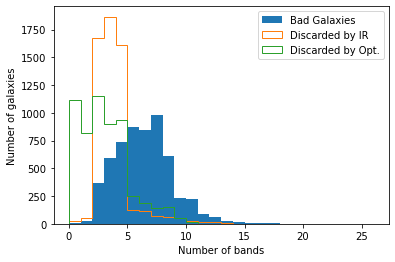

In [14]:
%matplotlib inline

Tpins = []
TpinsIR = []
TpinsOp = []
for Lrow in CIG[BadGalaxies]:
    # All the bad galaxies
    Tpins.append(sum(~np.isnan(list(Lrow.as_void())[2:]))/2)
    # Galaxies discarded due to IR wavelegnths
    TpinsIR.append(sum(~np.isnan(list(Lrow.as_void())[22:]))/2)
    # Galaxies discarded due to Opt. wavelengths
    TpinsOp.append(sum(~np.isnan(list(Lrow.as_void())[2:22]))/2)
plt.hist(Tpins, bins=np.linspace(0, 26, 27), label='Bad Galaxies')
plt.hist(TpinsIR, bins=np.linspace(0, 26, 27),
         histtype='step', label='Discarded by IR')
plt.hist(TpinsOp, bins=np.linspace(0, 26, 27),
         histtype='step', label='Discarded by Opt.')
plt.ylabel('Number of galaxies')
plt.xlabel('Number of bands')
plt.legend()

Most of the `BadGalaxies` are located in a large range of redshifts, mainly affecting galaxies at redshifts above $z=1$. This means that some of these galaxies are not well covered in some of the selected instruments and/or that the photometric values are not well constrained.

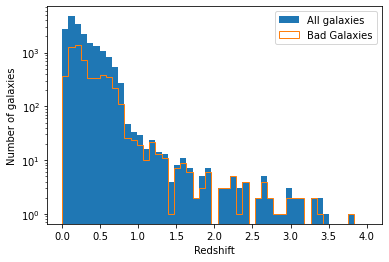

In [15]:
Redbins = np.linspace(0, 4, 50)
plt.hist(CIG['redshift'], bins=Redbins, label='All galaxies')
plt.hist(CIG[BadGalaxies]['redshift'], bins=Redbins, histtype='step', label='Bad Galaxies')
plt.xlabel('Redshift')
plt.ylabel('Number of galaxies')
plt.yscale('log')
plt.legend()

We save in a different file those galaxies that do not fulfill the energy balance we want. And then, we removed them from the sample.

In [16]:
CIG[BadGalaxies].write('../Data/Complementary/CIGPhot_BadEnergyBalance.tbl', format='ascii')

In [17]:
# Remove galaxies with bad energy balance coverage
CIG.remove_rows(BadGalaxies)

## Separating galaxies depending on redshift for the CIGALE photometry files

We found that most of our sample are below $z=1$, with a maximum at $z=3.48$, so we are going to split the galaxies in ten different groups/files to split the CIGALE runs and avoid computational overwork in CIGALE.

In [18]:
cnt, zbin = np.histogram(CIG['redshift'], bins=np.linspace(-0.01, 3.48, 350))
z_splits = np.percentile(zbin[:-1][cnt > 0], np.linspace(0, 100, 11))
z_splits[-1] += 0.01  # To add the last galaxy
group_zfile = np.digitize(CIG['redshift'], z_splits)

Now we save the files for each group and count the number of galaxies per group.

In [19]:
csd = 0
for i in range(1, max(group_zfile)+1):
    csd += len(CIG[group_zfile == i])
    print('Group %i with %d galaxies' % (i, len(CIG[group_zfile == i])))
    CIG[group_zfile == i].write('../Data/Interim/CIGPhot_EnergyBal_'+str(i)+'.tbl',
                                format='ascii')
assert len(CIG) == csd

Group 1 with 3828 galaxies
Group 2 with 3900 galaxies


Group 3 with 2154 galaxies
Group 4 with 1556 galaxies
Group 5 with 986 galaxies
Group 6 with 539 galaxies
Group 7 with 157 galaxies


Group 8 with 26 galaxies
Group 9 with 14 galaxies
Group 10 with 13 galaxies


We plot the distribution on redshift, with the bins defined for each final group.

Text(0, 0.5, 'Counts')

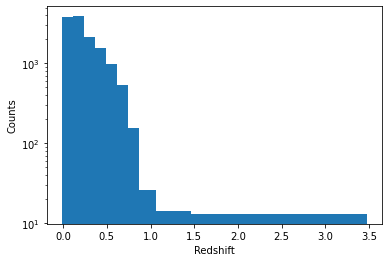

In [20]:
plt.hist(CIG['redshift'], bins=z_splits, log=True)
plt.xlabel('Redshift')
plt.ylabel('Counts')

Finally, we also save a file for all the galaxies, as in some cases this file is useful.

In [21]:
CIG.write('../Data/Final/CIGPhot_EnergyBal_All.tbl', format='ascii')

These files are used as an input to CIGALE (Step 5), not show as a notebook. The results of using CIGALE and their respective configuration are in a complementary repository. 

##### Notebook info

In [22]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.25.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 4.2

json      : 2.0.9
re        : 2.2.1
logging   : 0.5.1.2
numpy     : 1.19.5
matplotlib: 3.2.2
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
autopep8  : 1.5.7

Watermark: 2.1.0

